<a href="https://colab.research.google.com/github/Graylab/FLAb/blob/main/examples/FLAb_ZeroShotExample_IgLM_Expression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<font color='#3399CC' size=6> FLAb tutorial: Benchmarking a protein language model for antibody expression prediction </font>**


A prominent application of machine learning in therapeutic antibody design is the development of models that can generate or screen antibody candidates with a high probability of success in manufacturing and clinical trials. Here we will investigate if a pretrained protein language model can be used to screen antibody candidates that have desirable levels of expression.

**<font color='#3399CC' size = 5> Installation </font>**

We will investigate whether IgLM, an autoregressive antibody language model, can be used to predict antibody expression. More information of the IgLM model can be found here: https://github.com/Graylab/IgLM

In [ ]:
!pip install iglm

**<font color='#3399CC' size = 5> Dataset Analysis </font>**

Antibody expression is the process by which cells, often genetically engineered, produce antibodies. This can occur within organisms or in laboratory settings, Efficient expression is crucial for generating sufficient quantities of antibodies for research or therapeutic purposes. We'll use a dataset from Koenig et al. which introduces point mutations to the anti-VEGF antibody G6.31 and investiagtes the improvement in expression with respect to a wildtype antibody (`enrichment ratio`). The favorable fitness direction is indicated by a higher enrichment ratio. The columns `heavy` and `light` contain the antibody heavy and light chain sequences of the antibody variable domain.

Below we plot the range of enrichment ratios present in the dataset. It has a bimodel distribution with a mean enrichment ratio of 1.0 (i.e. no improvement or loss of expression).

In [ ]:
import pandas as pd
df = pd.read_csv("https://github.com/Graylab/FLAb/blob/main/data/expression/koenig2017mutational_er_g6.csv?raw=true")
df.head()

,heavy,light,enrichment ratio,fitness
0,EAQLVESGGGLVQPGGSLRLSCAASGFTISDYWIHWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQDVSTAVAWYQQKPGKAPKL...,0.819679,0.819679
1,ECQLVESGGGLVQPGGSLRLSCAASGFTISDYWIHWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQDVSTAVAWYQQKPGKAPKL...,0.328397,0.328397
2,EDQLVESGGGLVQPGGSLRLSCAASGFTISDYWIHWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQDVSTAVAWYQQKPGKAPKL...,1.585834,1.585834
3,EEQLVESGGGLVQPGGSLRLSCAASGFTISDYWIHWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQDVSTAVAWYQQKPGKAPKL...,1.806183,1.806183
4,EFQLVESGGGLVQPGGSLRLSCAASGFTISDYWIHWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQDVSTAVAWYQQKPGKAPKL...,1.452152,1.452152


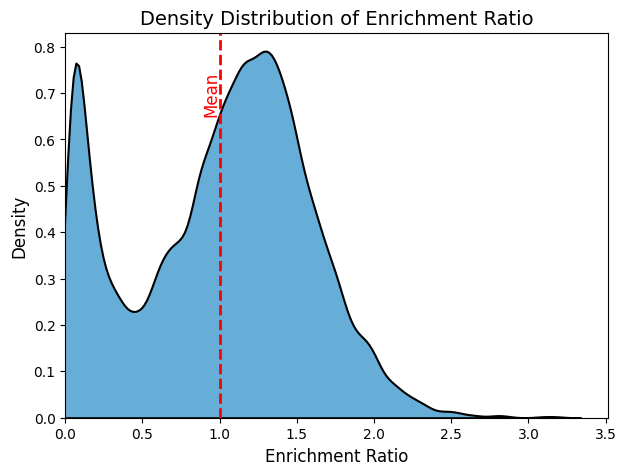

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,5))

# Density plot
sns.kdeplot(
    df['enrichment ratio'],
    fill=True,
    color='#0077BE',
    linewidth=1.5,
    edgecolor='black',
    alpha=0.6,
    bw_adjust=0.5
)

plt.title('Density Distribution of Enrichment Ratio', fontsize=14)
plt.xlabel('Enrichment Ratio', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Force x-axis to start at 0
plt.xlim(left=0)

# Mean (average value)
mean_val = df['enrichment ratio'].mean()
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2)
plt.text(mean_val, plt.ylim()[1]*0.9, 'Mean',
         color='red', fontsize=12, rotation=90, va='top', ha='right')

plt.show()


**<font color='#3399CC' size = 5> Zero-shot scoring with IgLM </font>**

A common application of protein language models in fitness prediction is in a zero-shot setting, where a protein language models confidence is used to rank sequences, without any additional fine-tuning with dataset-specific sequences.

For zero-shot benchmarking, we use the antibody variable region sequence as inputs for each model to assess their predictive capabilities, based on the corresponding model’s perplexity scores (averaged over all residues in the heavy and light chains). We report the Spearman’s correlations to establish the connection between the model uncertainty values and the fitness metrics associated with the sequences in the dataset. If a protein language model implicitly captures the biophysical landscapes of a pretraining set of antibodies or general proteins during training, it should assign high confidence (low perplexity) to new, previously unseen antibodies that have high expression and low confidence (high perplexity) to new, low-expression antibodies.

In [ ]:
from scipy.stats import spearmanr
import math
from iglm import IgLM

iglm = IgLM()

def iglm_score(seq, chain_token):
    """
    Calculate iglm PPL of a given sequence
    """
    log_likelihood = iglm.log_likelihood(seq, chain_token, "[HUMAN]")
    return math.exp(-log_likelihood)


def score(method, df):
    """
    input: df with columns: heavy,
                            light,
                            fitness
    output: pearson correlation and pvalue
    """

    df = pd.read_csv(df, nrows=100)

    ### CALCULATE PERPLEXITIES ###
    # for dataframe with heavy,light (Fvs)
    df['heavy_perplexity'] = df['heavy'].apply(lambda seq: method(seq, "[HEAVY]"))
    df['light_perplexity'] = df['light'].apply(lambda seq: method(seq, "[LIGHT]"))

    # Calculate average perplexity
    df['average_perplexity'] = (df['heavy_perplexity'] + df.get('light_perplexity', 0)) / 2

    # Compute Spearman's correlation
    corr_ppl, p_value_ppl = spearmanr(df['average_perplexity'], df['fitness'])

    return corr_ppl, p_value_ppl, df


In [ ]:
corr_ppl, p_value_ppl, new_df = score(iglm_score, "https://github.com/Graylab/FLAb/blob/main/data/expression/koenig2017mutational_er_g6.csv?raw=true")

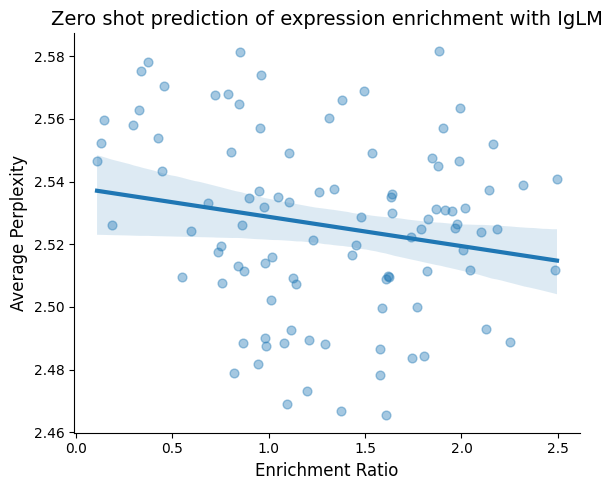

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))

# Scatter + smooth fit line with shaded confidence interval
sns.regplot(
    x='enrichment ratio',
    y='average_perplexity',
    data=new_df,
    scatter_kws={'alpha':0.4, 's':40},
    line_kws={'color':'#1f77b4', 'linewidth':3},
    ci=95  # keep confidence interval shading
)

plt.xlabel("Enrichment Ratio", fontsize=12)
plt.ylabel("Average Perplexity", fontsize=12)
plt.title("Zero shot prediction of expression enrichment with IgLM", fontsize=14)

sns.despine()
plt.tight_layout()
plt.show()

We observe a negative correlation (although noisy and weak) between enrichment ratio and model perplexity, indicating that IgLM likelihood has some understanding of what mutations to the G6.31 antibody will lead to improved expression. This may also indicate IgLM is capable of expression prediction for other antibodies, or suggest point mutations to improve expression. This process can be repeated for other protein language models to determine which has the strongest signal of expression.